## Import libraries

In [1]:
import os
import librosa
import numpy as np
import random
import glob
from collections import Counter
from typing import Callable, Any, List, Tuple
from scipy.spatial.distance import cdist
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from itertools import groupby

# Suppress specific UserWarning and FutureWarning from sklearn.cluster
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

## Utility functions

In [6]:
def detect_key(chroma_vals: np.ndarray) -> Tuple[str, str]:
    """Detect the key of a musical piece using the Krumhansl-Schmuckler key-finding algorithm."""
    # Krumhansl-Kessler key profiles for major and minor keys
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

    # Normalize key profiles
    major_profile /= np.linalg.norm(major_profile)
    minor_profile /= np.linalg.norm(minor_profile)

    # Calculate the correlation with the major and minor profiles using circular shift
    major_correlations = []
    minor_correlations = []
    for i in range(12):
        major_correlations.append(np.corrcoef(chroma_vals, np.roll(major_profile, i))[0, 1])
        minor_correlations.append(np.corrcoef(chroma_vals, np.roll(minor_profile, i))[0, 1])

    # Determine the detected key and mode
    max_major_idx = np.argmax(major_correlations)
    max_minor_idx = np.argmax(minor_correlations)

    if major_correlations[max_major_idx] > minor_correlations[max_minor_idx]:
        detected_key_idx = max_major_idx
        mode = 'major'
    else:
        detected_key_idx = max_minor_idx
        mode = 'minor'

    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    detected_key = note_names[detected_key_idx]
    print(f"Key: {detected_key} {mode}")

    return detected_key, mode


def calculate_ki_chroma(waveform: np.ndarray, sr: int, hop_length: int) -> np.ndarray:
    """
    Calculate a normalized, key-invariant chromagram for a given audio waveform,
    aligning the tonal center with C major for both major and minor keys.
    """
    chromagram = librosa.feature.chroma_cqt(y=waveform, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())
    chroma_vals = np.sum(chromagram, axis=1)
    detected_key, mode = detect_key(chroma_vals)

    key_indices = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    detected_key_idx = key_indices.index(detected_key)

    # Calculate the shift needed to align the detected key or its relative major with C
    if mode == 'major':
        shift_amount = -detected_key_idx
    else:  # For minor keys, calculate the shift to the relative major, then to C
        relative_major_idx = (detected_key_idx + 3) % 12
        shift_amount = -relative_major_idx

    key_invariant_chroma = np.roll(chromagram, shift=shift_amount, axis=0)
    print(f"Key-invariant chromagram aligned with C major (detected key: {detected_key} {mode})")
        
    return librosa.util.normalize(key_invariant_chroma, axis=1)

def calculate_rms_energy(y: np.ndarray, hop_length: int) -> np.ndarray:
    """Calculate the RMS energy for each frame of the given audio waveform."""
    S, _ = librosa.magphase(librosa.stft(y, hop_length=hop_length))
    rms = librosa.feature.rms(S=S, hop_length=hop_length)[0]
    rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))
    return rms_normalized
    

def create_beat_grid(beats: np.ndarray, tempo: float, sr: int, hop_length: int, duration: float) -> np.ndarray:
    """Generate beat grid within the duration of a song. Returns beat grid in time units"""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    num_beats_forward = int((duration - first_beat_time) / seconds_per_beat)
    num_beats_backward = int(first_beat_time / seconds_per_beat) + 1
    beat_times_forward = first_beat_time + np.arange(num_beats_forward) * seconds_per_beat
    beat_times_backward = first_beat_time - np.arange(1, num_beats_backward) * seconds_per_beat
    beat_grid = np.concatenate((beat_times_backward[::-1], beat_times_forward))
    return beat_grid


def beat_sync(y: np.ndarray, feature: np.ndarray, sr: int, hop_length: int, time_signature: int = 4) -> Tuple[np.ndarray, np.ndarray]:
    """Sync the features to a beat grid."""
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    beat_grid = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration)
    beat_frames = librosa.util.fix_frames(librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length))
    feature_beat_synced = librosa.util.sync(feature, librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length), aggregate=np.mean)
    print(f"Audio features beat-synchronized. Tempo: {tempo:.2f} BPM.")
    return feature_beat_synced, beat_frames


def hmm_sequence(feature: np.ndarray, n_states: int, covariance_type: str = 'tied') -> np.ndarray:
    """Perform HMM-based sequence analysis on the input feature."""
    valid_covariance_types = ['spherical', 'diag', 'full', 'tied']
    if covariance_type not in valid_covariance_types:
        raise ValueError(f"covariance_type must be one of {valid_covariance_types}, got '{covariance_type}' instead.")
    
    model = hmm.GaussianHMM(n_components=n_states, covariance_type=covariance_type, n_iter=1000)
    model.fit(feature.T)
    state_sequence = model.predict(feature.T)

    print(f"{len(state_sequence)} HMM state sequences created.")

    return state_sequence


def sequence_to_histogram(state_sequence: np.ndarray, n_states: int, histogram_length: int) -> np.ndarray:
    """Create L2-normalized histograms of the HMM state sequence over sliding windows."""
    num_histograms = len(state_sequence) - histogram_length + 1
    histograms = np.zeros((num_histograms, n_states))
    
    for i in range(num_histograms):
        histograms[i, :] = np.bincount(state_sequence[i:i+histogram_length], minlength=n_states)
    
    histograms = normalize(histograms, axis=1, norm='l2')

    return histograms

    
def cluster_histograms(histograms: np.ndarray, n_clusters: int) -> np.ndarray:
    """Cluster histograms using K-means and return cluster labels for each frame."""
    kmeans = KMeans(n_clusters=n_clusters).fit(histograms)
    cluster_labels = kmeans.labels_
    
    # Print the number of histograms in each cluster
    cluster_counts = Counter(cluster_labels)
    print(f"{n_clusters} clusters created.")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} histograms")
    
    return cluster_labels


def smooth_cluster_labels(cluster_labels: np.ndarray, min_sequence_length: int = 16) -> np.ndarray:
    """Smooths cluster labels by combining short sequences with adjacent sequences."""
    # Convert cluster_labels to a list of tuples (cluster_number, sequence_length)
    cluster_tuples = [(k, len(list(g))) for k, g in groupby(cluster_labels)]

    # Smooth short sequences
    smoothed_tuples = []
    i = 0
    while i < len(cluster_tuples):
        if cluster_tuples[i][1] < min_sequence_length:
            if i == 0:
                smoothed_tuples.append((cluster_tuples[i+1][0], cluster_tuples[i][1] + cluster_tuples[i+1][1]))
                i += 2
            elif i == len(cluster_tuples) - 1:
                smoothed_tuples[-1] = (smoothed_tuples[-1][0], smoothed_tuples[-1][1] + cluster_tuples[i][1])
                i += 1
            else:
                prev_cluster, prev_length = cluster_tuples[i-1]
                next_cluster, next_length = cluster_tuples[i+1]
                if prev_cluster == next_cluster and min(prev_length, next_length) > cluster_tuples[i][1]:
                    smoothed_tuples[-1] = (prev_cluster, prev_length + cluster_tuples[i][1] + next_length)
                    i += 2
                elif prev_length <= next_length:
                    smoothed_tuples[-1] = (prev_cluster, prev_length + cluster_tuples[i][1])
                    i += 1
                else:
                    smoothed_tuples.append((next_cluster, cluster_tuples[i][1] + next_length))
                    i += 2
        else:
            smoothed_tuples.append(cluster_tuples[i])
            i += 1

    # Reconstruct the smoothed cluster_labels
    smoothed_labels = np.repeat([t[0] for t in smoothed_tuples], [t[1] for t in smoothed_tuples])

    return smoothed_labels


def label_to_timeseg(labels: np.ndarray, beat_frames: np.ndarray, sr: int, hop_length: int, output_type: str = 'time') -> np.ndarray:
    """Detects changes in cluster labels and maps these changes to the original song's frames or time."""
    change_indices = np.where(np.diff(labels) != 0)[0] + 1
    change_frames = beat_frames[change_indices]
    print(f"{len(change_frames)} segment boundaries detected.")
    
    if output_type == 'time':
        change_times = librosa.frames_to_time(change_frames, sr=sr, hop_length=hop_length)
        return change_times
    elif output_type == 'frames':
        return change_frames
    else:
        raise ValueError("output_type must be either 'time' or 'frames'")


def plot_segmentation(feature: np.ndarray, feature_type: str, sr: int, hop_length: int, segment_times: np.ndarray, color_map: str = 'Spectral', segment_color: str = 'black'):
    """Plot audio features with segmentation boundaries."""
    fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)  # Width: 1200 pixels, Height: 288 pixels
    if feature_type == 'chroma':
        librosa.display.specshow(feature, y_axis='chroma', x_axis='time', sr=sr, hop_length=hop_length, ax=ax, cmap=color_map)

    # Plot vertical lines for each segment time
    for time in segment_times:
        ax.axvline(x=time, color='black', linestyle='-.', linewidth=2)  

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Pitch Class', fontsize=12)
    plt.title(f"{feature_type} with Segment Boundaries", fontsize=14)
    plt.show()



## Main 

In [28]:
np.random.seed(42)
random.seed(11)

# Parameters
hop_length = 128 # 128 @ 12kHz gives a similar frame rate to a hop length of 512 @ 48kHz.
sr = 12000
n_hmm_states = 8
histogram_length = 7
n_clusters = 3

# Choose random song  
df = pd.read_csv('../data/dataframes/clean_labeled.csv') 
random_song_id = random.choice(df["SongID"].unique())
print(f"Random Song ID: {random_song_id}")

# Load audio and extract beats and chroma features
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'
y, _ = librosa.load(audio_file, sr=sr)
y_harm, y_perc = librosa.effects.hpss(y) 

chromagram = calculate_ki_chroma(y_harm, sr=sr, hop_length=hop_length)
chroma_sync, beat_frames = beat_sync(y=y_perc, feature=chromagram, sr=sr, hop_length=hop_length, time_signature=4)
chroma_state_sequences = hmm_sequence(chroma_sync, n_states=n_hmm_states, covariance_type='tied')
histograms = sequence_to_histogram(chroma_state_sequences, n_states=n_hmm_states, histogram_length=histogram_length)
cluster_labels = cluster_histograms(histograms, n_clusters=n_clusters)
smoothed_labels = smooth_cluster_labels(cluster_labels, min_sequence_length=16)
segment_times = label_to_timeseg(labels=smoothed_labels, beat_frames=beat_frames, sr=sr, hop_length=hop_length, output_type='time')

# Plot
#plot_segmentation(feature=chromagram, feature_type='Chroma', sr=sr, hop_length=hop_length, segment_times=segment_times)


Random Song ID: 393
Key: C# major
Key-invariant chromagram aligned with C major (detected key: C# major)
Audio features beat-synchronized. Tempo: 130.81 BPM.
463 HMM state sequences created.
3 clusters created.
Cluster 1: 208 histograms
Cluster 0: 87 histograms
Cluster 2: 162 histograms
5 segment boundaries detected.


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


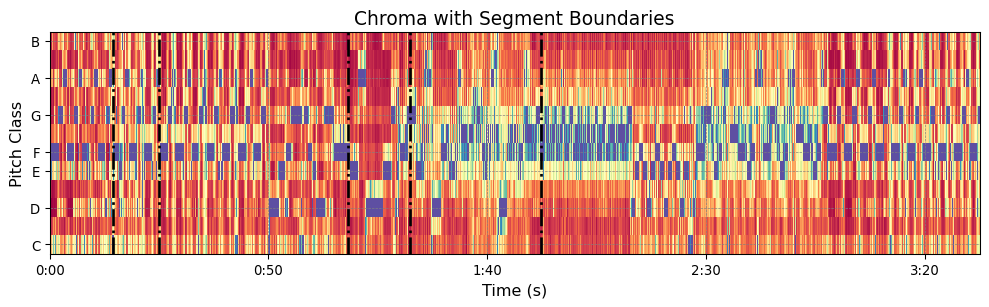

In [30]:
print(cluster_label
plot_segmentation(feature=chromagram, feature_type='Chroma', sr=sr, hop_length=hop_length, segment_times=label_to_timeseg(labels=cluster_labels, beat_frames=beat_frames, sr=sr, hop_length=hop_length, output_type='time'))

In [22]:
rms_energy = calculate_rms_energy(y=y, hop_length=hop_length)
rms_sync, beat_frames = beat_sync(y=y_perc, feature=rms_energy, sr=sr, hop_length=hop_length)
rms_sequences = hmm_sequence(rms_sync.reshape(-1, 1), n_states=n_hmm_states, covariance_type='tied')
rms_hist = sequence_to_histogram(rms_sequences, n_states=n_hmm_states, histogram_length=histogram_length)
rms_clusters = cluster_histograms(rms_hist, n_clusters=n_clusters)
rms_clusters




Fitting a model with 138795 free scalar parameters with only 463 data points will result in a degenerate solution.


Audio features beat-synchronized. Tempo: 130.81 BPM.


ValueError: n_samples=1 should be >= n_clusters=60.

In [21]:
chroma_sync.shape
rms_sync.shape

(463,)